In [1]:
#this note book check if tcax.z.hat provides additional info on top of W, X
#fits a model:  Z_jh ~ W_h + X_j + Z_jh.tcax across i, for all i, h on the sc-stephenson data 

In [12]:
library("MASS")
library("testit")
library("pracma")
library("data.table")
library("matrixStats")
#library("compositions")

# #source("analysis.utils.r")

library("ggplot2")
library("ggpubr")
library("grid")
library("tidyr")
library("scales")
library("latex2exp")
library("hrbrthemes")
library("extrafont")
#library("ggpointdensity")

NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow

Registering fonts with R



In [3]:
#log.p.vals.mats: list of matrix. names are the source.ids, each matrix is features by some columns. each entry is a p val
#var.to.plt: character. column name in log.p.vals.mat of the variable to plot 
#source.ids: list of character. source to show
#visualize each source.id as a figure. different source.id will be shown as different panel. 
#each panel's x axis are features. y axis is negtive log pval
manplot = function(log.p.vals.mats, var.to.plt, source.ids){
    k = length(log.p.vals.mats)
    plts<- lapply(1:k, function(h){
        source.id = source.ids[h]
        df = as.data.frame(log.p.vals.mats[[source.id]])
        df[df>300] = 300
        df$j = 1:nrow(log.p.vals.mats[[source.id]]) 
        g = ggplot(df, aes(x = j, y = df[,var.to.plt])) +
            geom_point(alpha = 1, size = 1) + 
            ggtitle(paste0(source.id)) +  
            theme(plot.title = element_text(hjust = 0.5, size = 15))+ theme(text=element_text(size=15))+ 
            ylab("negative log10 p val") +
            #clean background 
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(),
                  panel.background = element_blank(), 
                  axis.title.x = element_blank(),
                  axis.line = element_line(colour = "black"))
        return(g)
    })
    return (egg::ggarrange(plots = plts, align = "h", widths = rep(1, k))) 

}

In [4]:
get_log_p_vals_mats = function(X, W, Z, Z.hat, num.stds = 2, constant_thr = 0.001){
# for each gene fit a joint model and reported the p-val on each terms
# per gene the outliers defined by the num.stds are removed
    res = list()
    for (source.id in colnames(W)){
            print(paste0("working on ", source.id))
        p.vals.mat  = list()
        for (j in 1:nrow(X)){
                constant.flag = F

            df = data.frame(Z.hat = Z.hat[source.id,j,], bulk = X[j, ], Z = Z[source.id,j,])
            df = cbind(df, W)

            x = X[j, ]
            mask = abs(x - mean(x)) <= num.stds * sd(x)
            df = df[mask, ]

            if(sd(df$Z.hat) <= constant_thr){
                #if no variance detected in celltype h, gene j, 
                #sample from random normal with same mean but variance 1
                df = df[, -1]
                constant.flag = T
            }

            # #not neccesary  #Column standardize
            #df = as.matrix(df[mask, ])
            #df = df/repmat(t(as.matrix(colSds(as.matrix(df)))),nrow(df),1 )
            #df = as.data.frame(df)

            fit = lm(formula = Z ~ 0 + ., data = df) # no intercept because W already co-linear 
            p.vals.mat[[j]] = t(summary(fit)$coefficients)["Pr(>|t|)", , drop = F]
            if(constant.flag){
                #put p = 1 
                Z.hat.p = matrix(1, 1, 1)
                colnames(Z.hat.p) = c("Z.hat")
                p.vals.mat[[j]] = cbind(Z.hat.p,p.vals.mat[[j]])
            }
        }
        p.vals.mat = Reduce(rbind, p.vals.mat)
        rownames(p.vals.mat) = rownames(X)
        res[[source.id]] = -log10(p.vals.mat)
    }
    return (res)
}

In [41]:
data.dir       = "../Data/RNA/Simulation-PBMC/sc-Stephenson_all.W_k_5_m_600_n_500_dirichlet_F_noiseZ_T_varThr_1e-04_filThr_1e-04_expQtl_0.5_enrich_T_etpRat_0.625_enrichRat_0.25_maxSds_3_scale.maxSds_Inf_scale.factor.thr_1e-04/"
res.dir        = "../Result/RNA/Simulation-PBMC/sc-Stephenson_all.W_k_5_m_600_n_500_dirichlet_F_noiseZ_T_varThr_1e-04_filThr_1e-04_expQtl_0.5_enrich_T_etpRat_0.625_enrichRat_0.25_maxSds_3_scale.maxSds_Inf_scale.factor.thr_1e-04/"

base.mdl.list       = readRDS(file.path(res.dir,"base.mdl.list.rds"))
cibersortx.mdl.list = readRDS(file.path(res.dir,"cibersortx.mdl.list.rds"))
tca.mdl.list        = readRDS(file.path(res.dir,"tca.mdl.list.rds"))
tcax.mdl.list       = readRDS(file.path(res.dir,"tcax.mdl.mp_0_vp_0.01_cp_0.01.list.rds"))

In [42]:
ts = 1:20
sim.data.list = list()  
for (t in ts){
    sim.data.list[[t]] = readRDS(file.path(data.dir,paste0("sim.data.rds.", t)))
}

In [43]:
sim.data = sim.data.list[[1]]
k = ncol(sim.data$W)
m = nrow(sim.data$X)
n = ncol(sim.data$X)
source.ids = colnames(sim.data$W)

[1] "CD4"  "NK"   "CD8"  "Mono" "B"

In [44]:

cibersortx.log.p.vals.mats = get_log_p_vals_mats(X = sim.data.list[[1]]$X.scale,
                                      W = sim.data.list[[1]]$W,
                                      Z = sim.data.list[[1]]$Z.scale,
                                      Z.hat = cibersortx.mdl.list[[1]]$Z.hat.eval,
                                      num.stds = 2)

[1] "working on CD4"
[1] "working on NK"
[1] "working on CD8"
[1] "working on Mono"
[1] "working on B"


In [45]:
base.log.p.vals.mats = get_log_p_vals_mats(X = sim.data.list[[1]]$X.scale,
                                      W = sim.data.list[[1]]$W,
                                      Z = sim.data.list[[1]]$Z.scale,
                                      Z.hat = base.mdl.list[[1]]$Z.hat.eval,
                                      num.stds = 2)

[1] "working on CD4"
[1] "working on NK"
[1] "working on CD8"
[1] "working on Mono"
[1] "working on B"


In [46]:
tca.log.p.vals.mats = get_log_p_vals_mats(X = sim.data.list[[1]]$X.scale,
                                      W = sim.data.list[[1]]$W,
                                      Z = sim.data.list[[1]]$Z.scale,
                                      Z.hat = tca.mdl.list[[1]]$Z.hat.eval,
                                      num.stds = 2)

[1] "working on CD4"
[1] "working on NK"
[1] "working on CD8"
[1] "working on Mono"
[1] "working on B"


In [47]:
tcax.log.p.vals.mats = get_log_p_vals_mats(X = sim.data.list[[1]]$X.scale,
                                      W = sim.data.list[[1]]$W,
                                      Z = sim.data.list[[1]]$Z.scale,
                                      Z.hat = tcax.mdl.list[[1]]$Z.hat.eval,
                                      num.stds = 2)

[1] "working on CD4"
[1] "working on NK"
[1] "working on CD8"
[1] "working on Mono"
[1] "working on B"


In [48]:
for (source.id in source.ids){
    base.log.p.vals.mats[[source.id]] = base.log.p.vals.mats[[source.id]][150:600, ]
    cibersortx.log.p.vals.mats[[source.id]] = cibersortx.log.p.vals.mats[[source.id]][150:600, ]
    tca.log.p.vals.mats[[source.id]] = tca.log.p.vals.mats[[source.id]][150:600, ]
    tcax.log.p.vals.mats[[source.id]] = tcax.log.p.vals.mats[[source.id]][150:600, ]
}

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


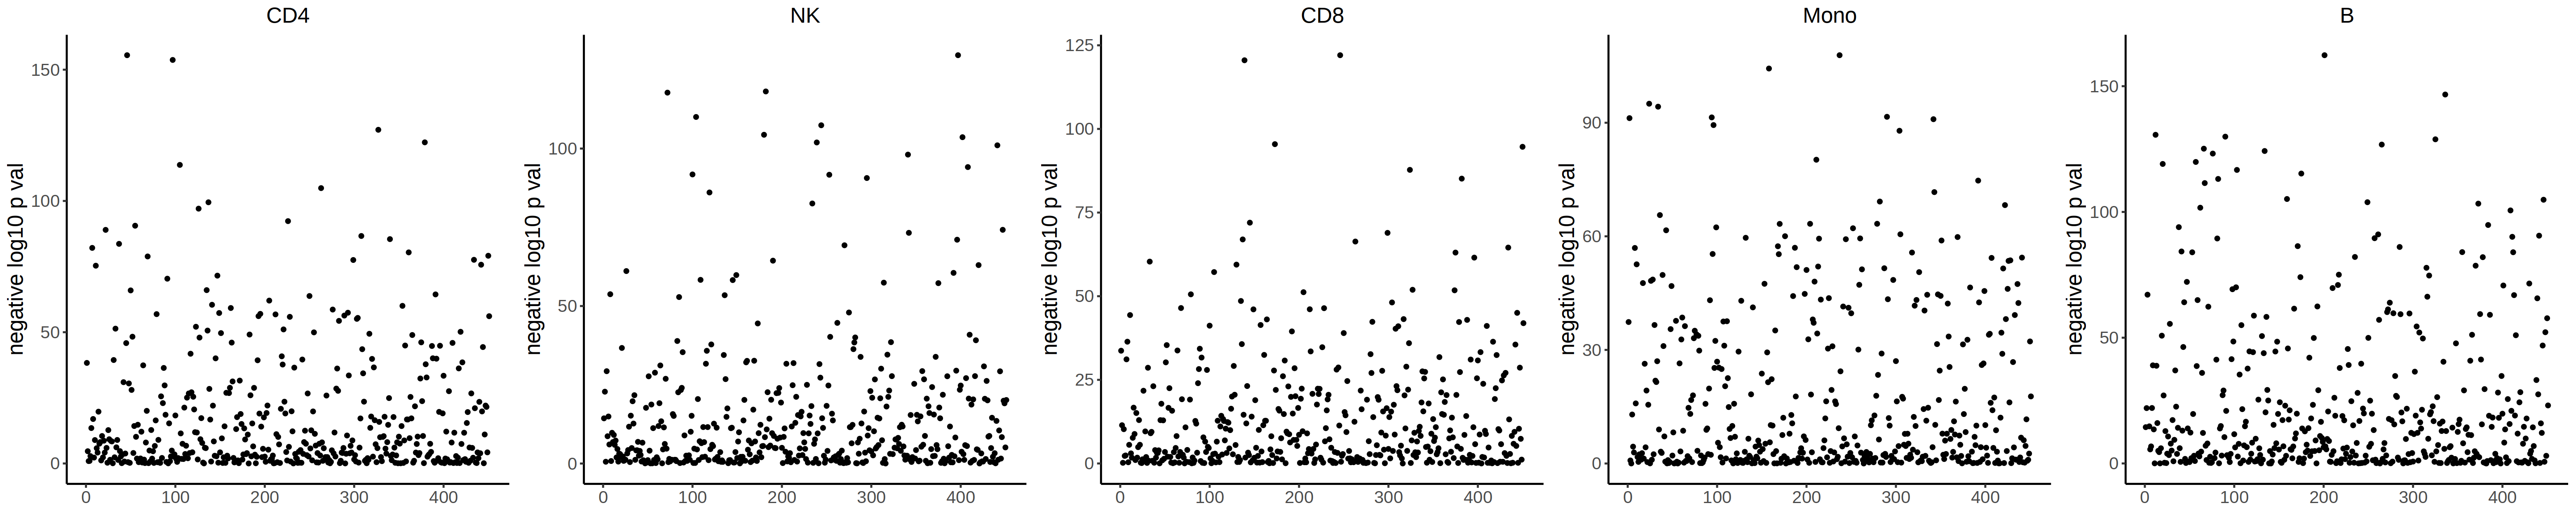

In [49]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(base.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


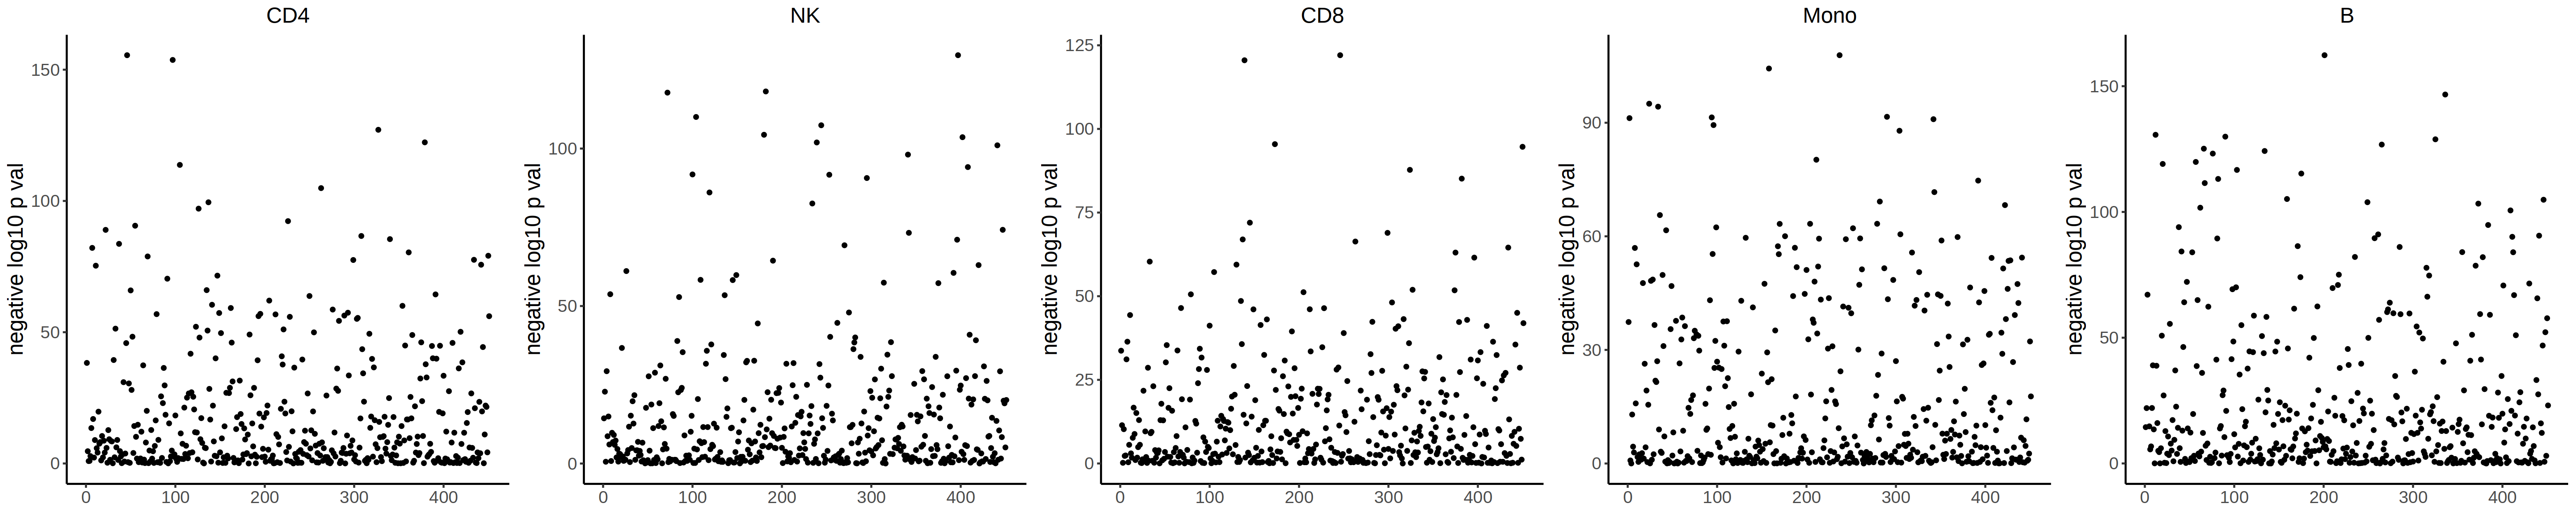

In [50]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(cibersortx.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


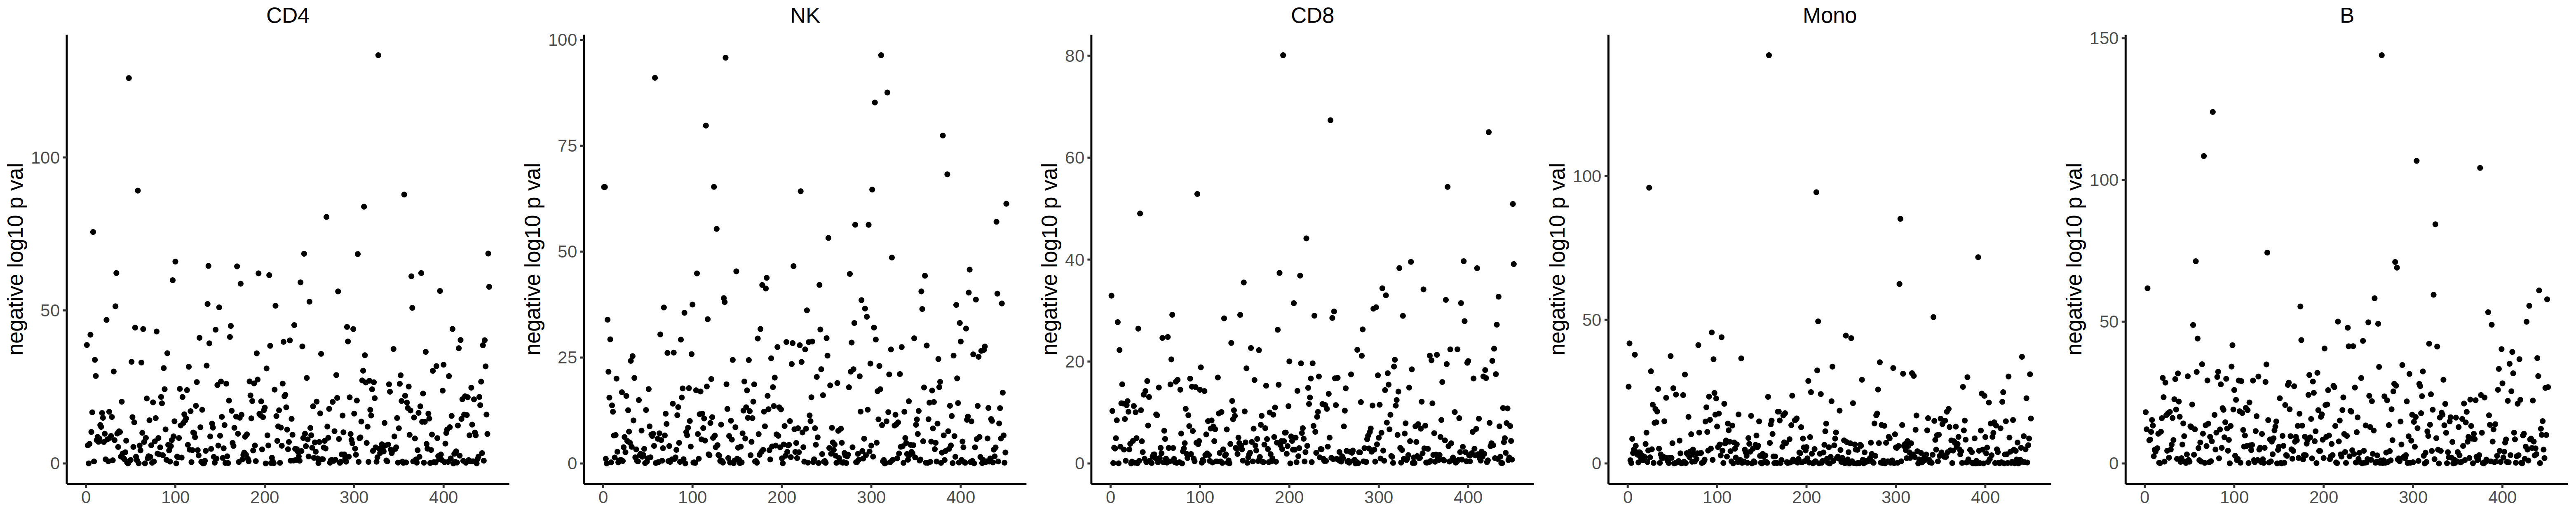

In [51]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(tca.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


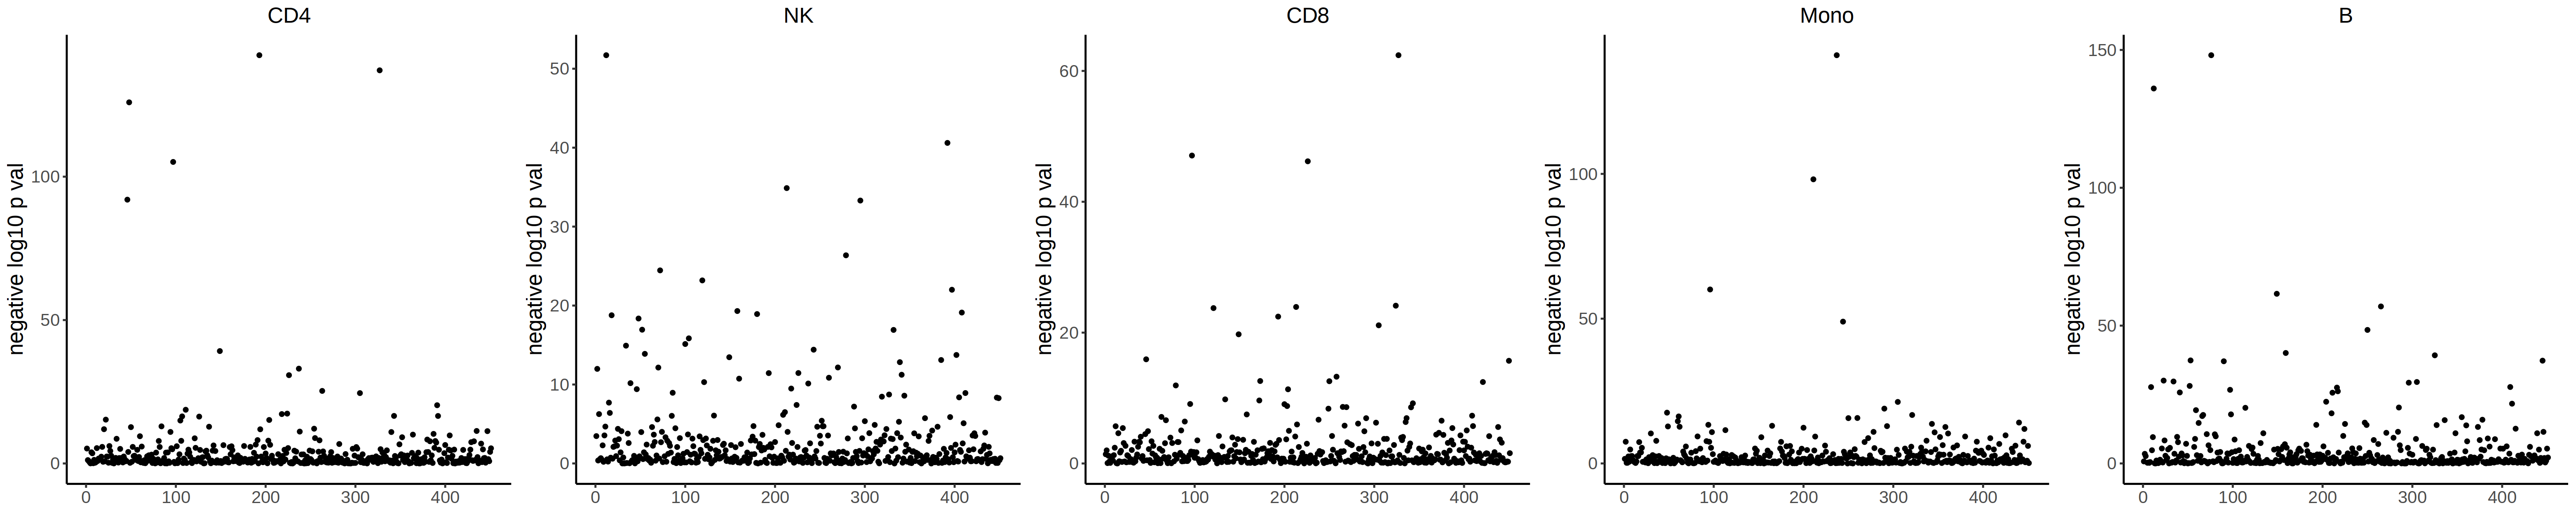

In [52]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(tcax.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


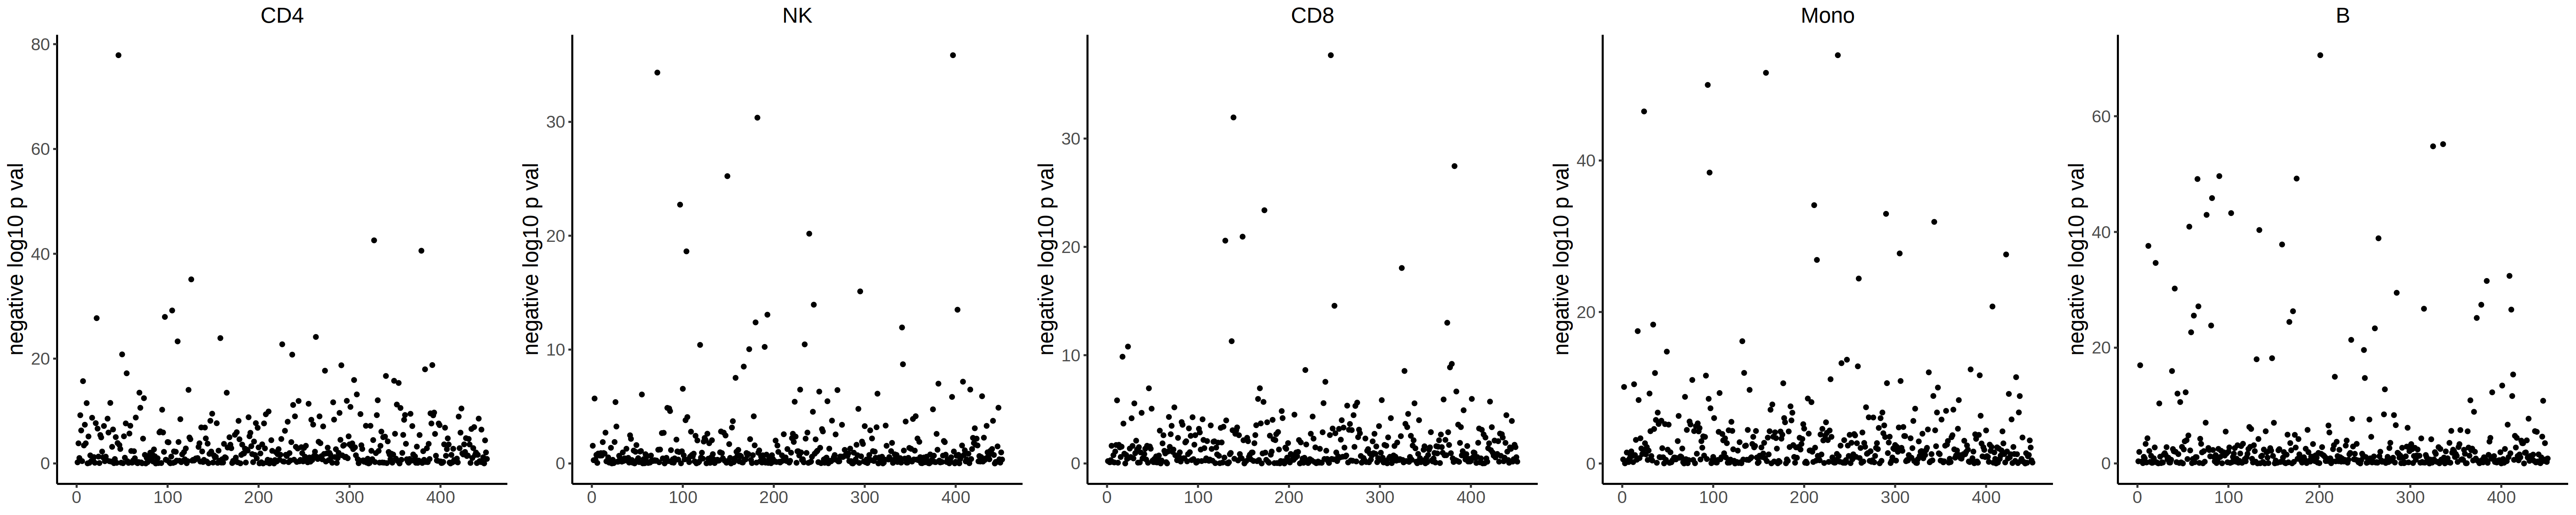

In [53]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(base.log.p.vals.mats, "Z.hat", source.ids = colnames(sim.data.list[[1]]$W))

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


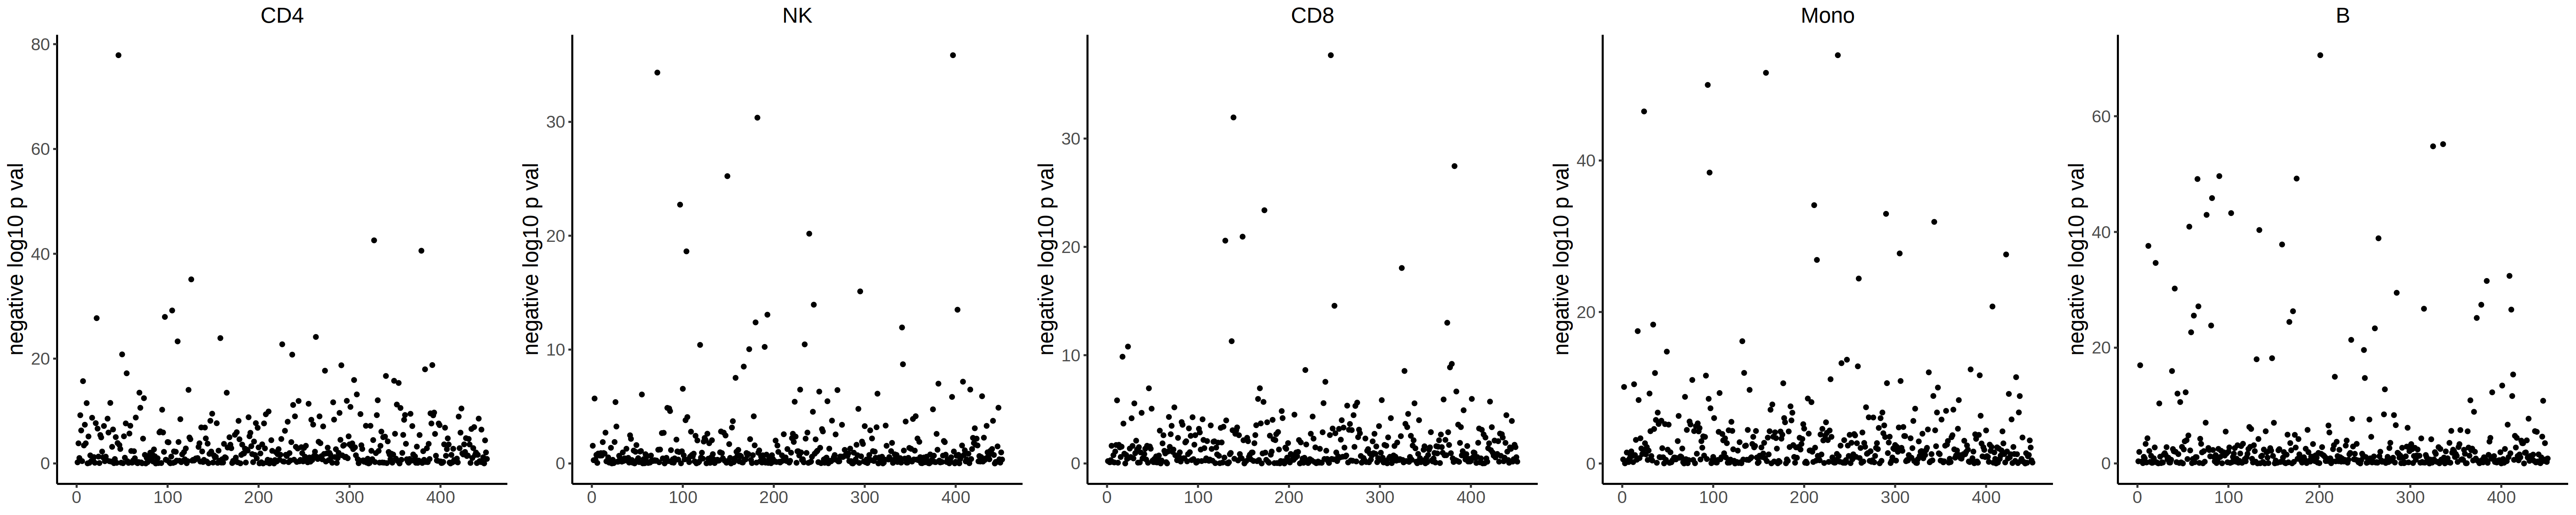

In [54]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(cibersortx.log.p.vals.mats, "Z.hat", source.ids = colnames(sim.data.list[[1]]$W))

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


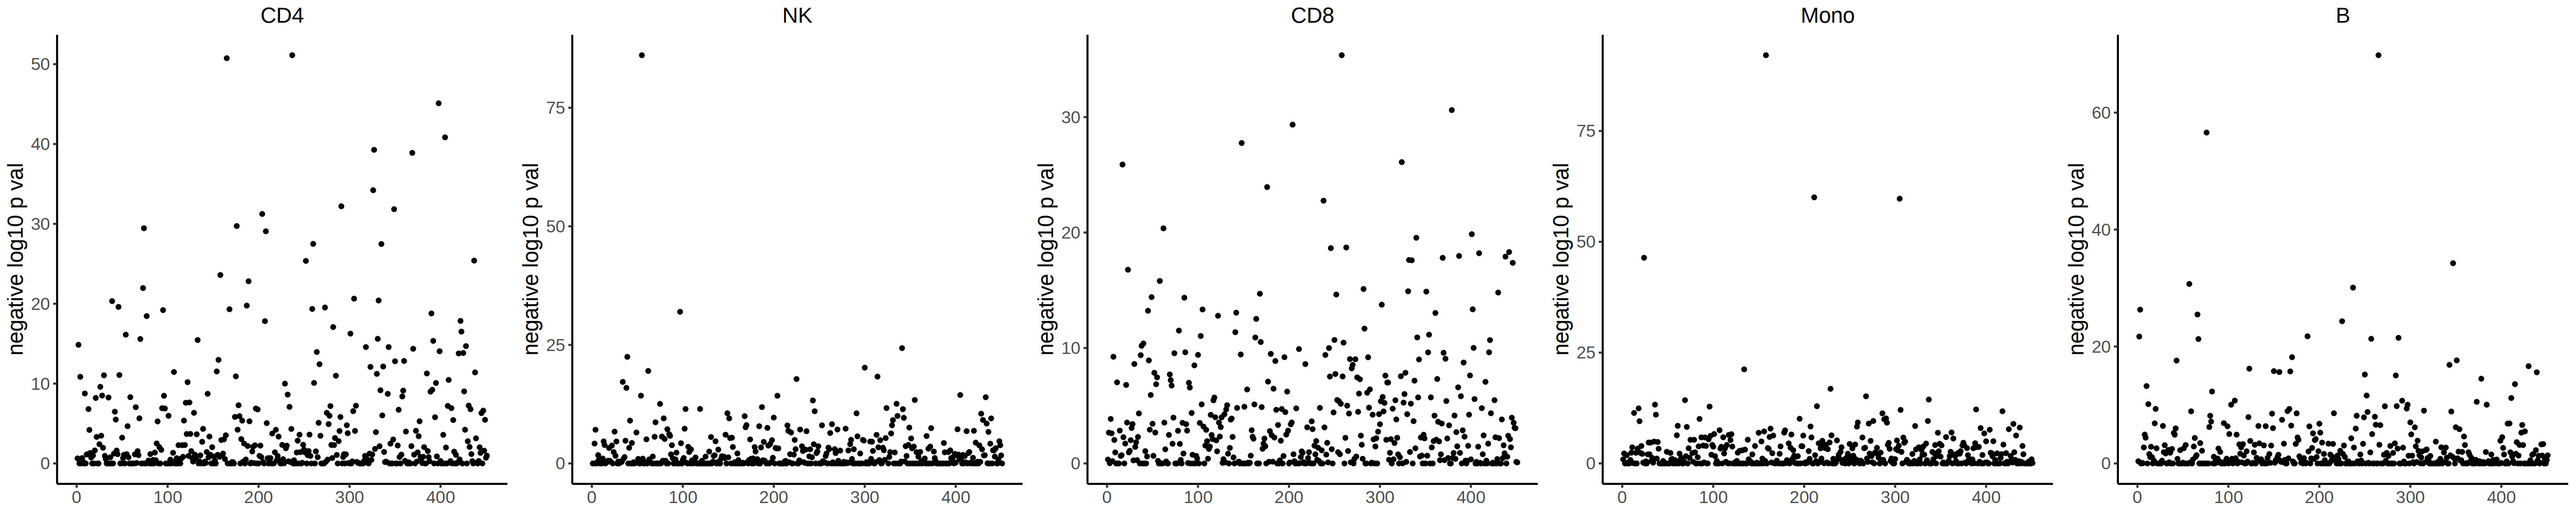

In [55]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(tca.log.p.vals.mats, "Z.hat", source.ids = colnames(sim.data.list[[1]]$W))

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


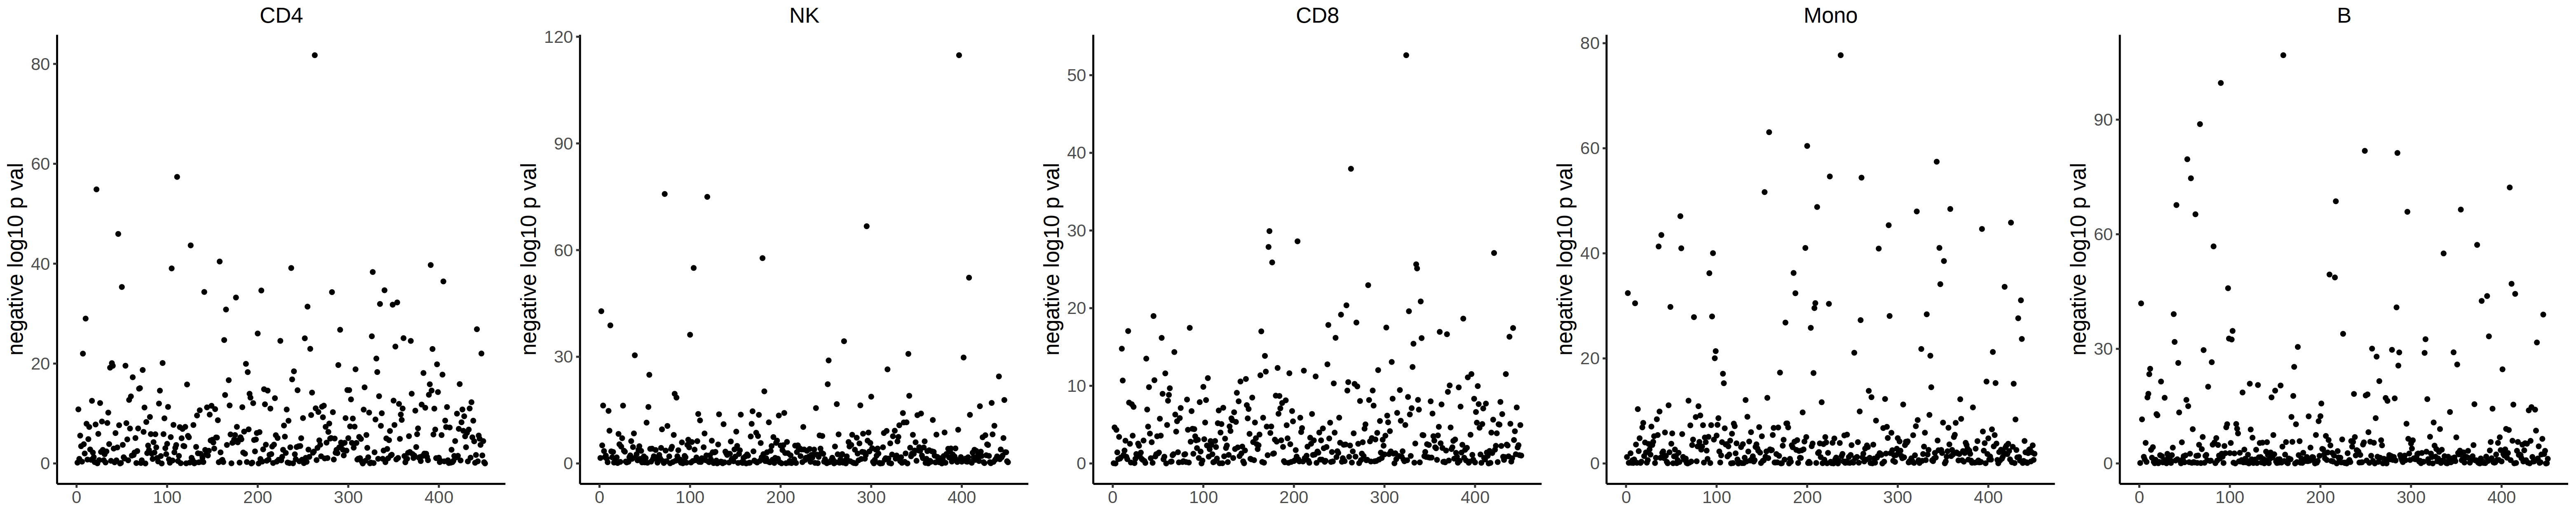

In [56]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(tcax.log.p.vals.mats, "Z.hat", source.ids = colnames(sim.data.list[[1]]$W))

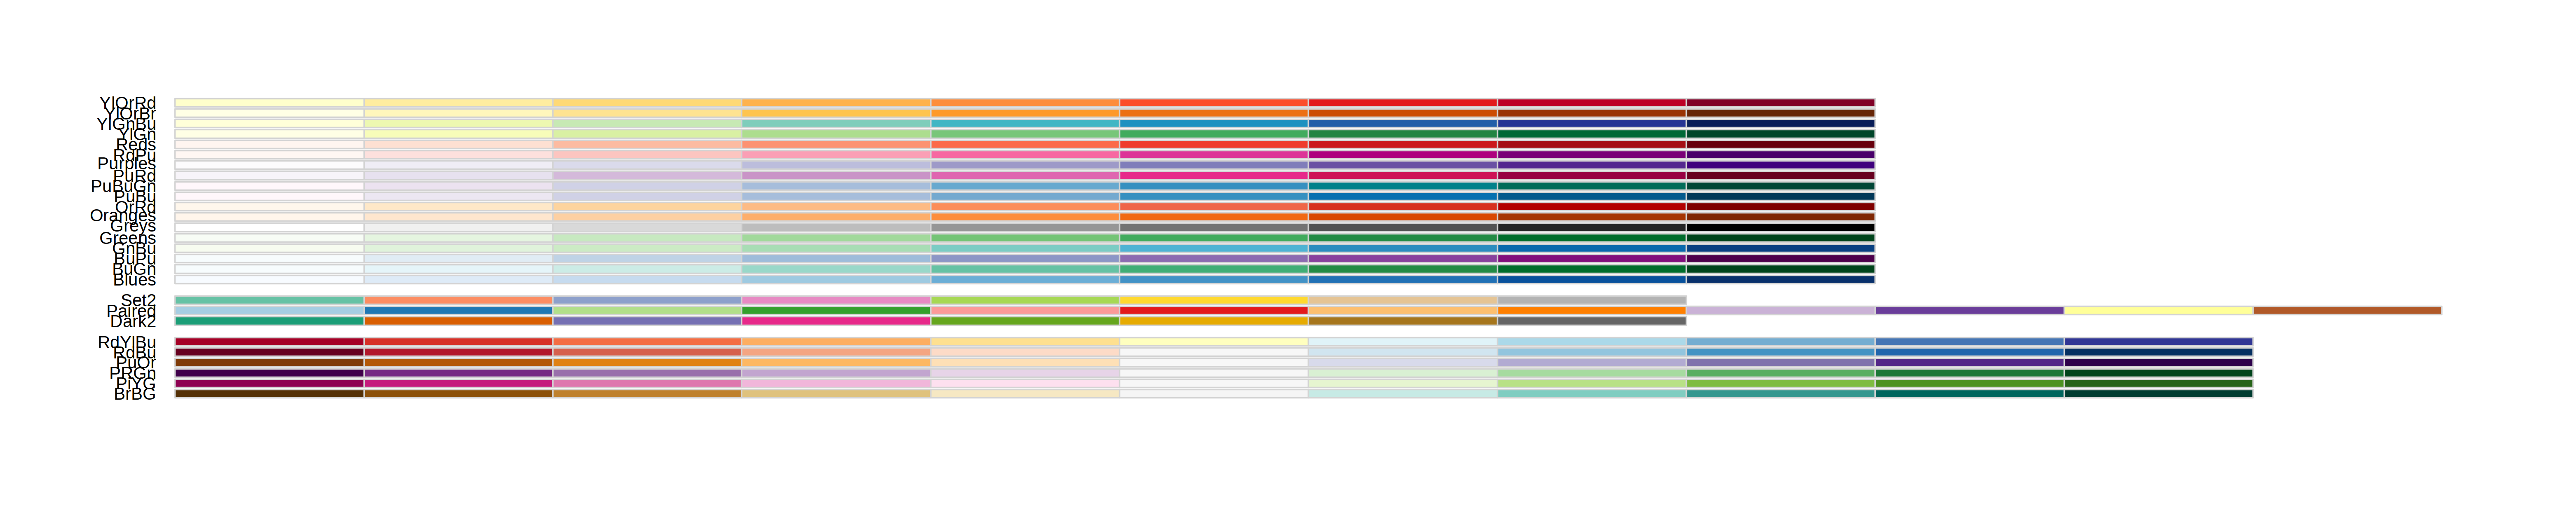

In [57]:

########################################### Color code ################################################
library(RColorBrewer)


display.brewer.all(colorblindFriendly = TRUE)
base.color = brewer.pal(n = 8, name = "Set2")[8]
bulk.color = brewer.pal(n = 8, name = "Set2")[7]
cibersortx.color = brewer.pal(n = 8, name = "Set2")[5]
tca.color  = brewer.pal(n = 8, name = "Set2")[3]
tcax.color = brewer.pal(n = 8, name = "Set2")[4]


In [58]:



sub.titles = c("CD4 T Cells",  "NK Cells",  "CD8  T  Cells",  "Monocytes",  "B  Cells")
#sub.titles = c("Cerebellum",  "Cerebellar Hemisphere",  "Caudate",  "Nucleus Accumbens",  "Putamen")


# x y label
# font size 





dot.alpha = 0.75
dot.size  = 3
title.size = 25
lab.size = 20
xlab.text = "Bulk"
ylab.text = "Deconvolution Tensor"


In [59]:
base.log.p.vals.mats[[source.ids[[1]]]]

Z.hat       bulk        CD4         NK           CD8         
HEBP2        0.21364574 38.30872795  0.73910334  4.119798202  0.141660015
APLP2        3.83884374  4.66691903  2.26167089  7.717879272  3.371884685
SNCB         1.03491846  0.91203878 11.67944198  5.741830881  0.797158453
METTL24      9.20274472  0.96513913  2.23886050  1.319192740  1.262501305
TRAM2        6.29621174  2.80504791  2.30500120  2.828770510  2.617681112
MIR34AHG     0.44408773 13.48719127  1.51517459  0.778874581  0.619288898
RGS16       15.70303058 82.11752838  0.04014413  3.464824823  3.768779367
ANXA4        3.43877205 16.94468210  0.23349169  0.736066658  0.058989575
TENM4        7.38944760  2.24687213  0.40523896  1.467253064  0.322280015
CFP          3.83923925  8.92147795  2.91615901  6.819017164  9.665232950
TRAV29DV5   11.51446141 75.33945548  2.43088244  8.680136605  8.046002349
ENAM         0.02014052  5.81483385  0.47046027  0.156345916  0.827562378
CDC25A       5.14647163  4.15458696  1.29344651  0.052764904  2.201727657
CHAC2        0.11764751 19.73752550  0.58408662  0.971619226  0.017674478
AL034405.1   1.53806969  7.54543726  2.71567629  0.198569397  1.292491949
AC008629.1   0.43971654  8.14928379  2.37359202  0.299354125  1.149305429
SCGB3A2      8.71914985  1.16687217  0.99383737  0.371374190  1.474134717
ROR2         0.74484619 10.46274994  0.35125407  1.786639591  0.271782258
HES1         1.21410540  2.31277609  1.98835839  0.284880852  0.363355214
IGHV1OR15.1  0.13212685  8.67879673  0.02764598  1.821627336  0.047303759
BHLHE40      7.68691539  4.14922214  1.08421032  0.001824717  0.004578757
CCR4        27.72130626 88.98787485  2.22665654 12.539519842 10.525582447
MMP9         6.64918560  5.93018728  1.77464574  0.743490702  1.057351131
GXYLT2       1.30745426  0.28337297  0.12625518  0.041245796  0.062110317
RGPD3        0.07680725 12.71072186  2.67196582  2.488350979  0.290409817
CD300A       5.42029264  9.22968601  0.05417441  2.686811031  0.864733285
AC002310.2   4.96714048  1.40248304  2.64485188  0.746956027  1.290653879
CTSH         2.27059574  8.55718971  0.03680485 11.364890634  2.448928462
ESPL1        1.17050242  8.39922771  1.46608573  0.095043290  1.260424103
EGR4         7.14989918  0.08732264  0.13909453  0.756073537  1.357164648
⋮           ⋮           ⋮           ⋮           ⋮            ⋮           
HESX1        5.87883562  1.28154911  0.43474802  2.42720646   1.96808613 
PLAGL2      10.48252507 11.70775179  3.50137463  4.64056211   1.71733938 
DSCAML1      1.91792822  1.65018286  2.50064475  1.03593702   0.28905834 
NID1         1.72144470  0.65638893  0.08292837  0.63919196   0.71131882 
RENBP        3.64483017 15.42066376  0.85058628  0.67103404   5.84159697 
PNP          2.19523928 19.58208377  1.90304009  2.24342037   0.40802768 
MARVELD1     4.82152791  0.26736097  0.53974519  1.51781368   1.36036767 
TCERG1L      1.42120255  6.08355884  1.22971996  0.32004964   1.30561720 
CNR2         1.51945913  1.04321525  0.14357487  0.89110067   0.21306082 
CARD19       4.68037241 26.68963265  3.82669294  2.71975953   0.10644707 
C7orf61      3.62067474  5.93024641  1.03837697  0.09548202   0.85302638 
DTNA         0.10564792  2.19074852  0.05120146  0.20929748   0.04212311 
TUBB2A       6.58185569 77.58354499  0.25593433  0.17530550  12.34230412 
CD34         1.03793006 21.04533856  1.09513902  0.14444756   0.27310690 
AQP9         2.92722699  0.34402394  0.92005732  2.51332432   0.13649216 
CASP5        6.93698312  0.16652405  0.23910020  0.81932551   0.16959064 
PTPRK        1.61354029  4.21377431  0.02516469  1.70411854   1.02053181 
ZDHHC19      2.07925190  2.02936754  0.15443799  1.96240833   0.30026001 
DAAM1        0.07623905 23.47005999  0.28443871  0.07765883   0.66374954 
LAT2         1.64809147  3.88768100  1.51580861  0.27806450   1.63614570 
CAMK4        8.55536050 75.71101319  5.20118540 13.65550921   8.91477825 
RMI2         0.44762478 19.83236869  0.14457854  0.22799050   0.78782711 
CD320        0.2

In [60]:
plot.df 

x           y           method  
1    114.60344   4.200432926 Baseline
2     57.13226   0.022950428 Baseline
3     83.74780   0.395745771 Baseline
4     39.31990   0.623433555 Baseline
5     32.47525   1.383294751 Baseline
6    175.42540   0.323814447 Baseline
7     31.94492   0.890363045 Baseline
8     67.72849   0.830092686 Baseline
9     96.12036   0.139118015 Baseline
10    31.77066   0.182902833 Baseline
11    64.68624   1.833783972 Baseline
12    21.69556   0.043719069 Baseline
13   114.85740   2.725719434 Baseline
14    86.26295   6.307989412 Baseline
15    36.60969   1.307789227 Baseline
16   102.09240   0.216879957 Baseline
17    83.11156   0.329752910 Baseline
18    37.18440   0.534946769 Baseline
19    30.54388   2.753991632 Baseline
20   116.21528   0.004398244 Baseline
21    31.95669   0.795463501 Baseline
22    32.02484   0.794475025 Baseline
23    42.26072   0.536419634 Baseline
24   173.65293   0.004694807 Baseline
25    43.76241   0.201774175 Baseline
26    22.15209   1.108576635 Baseline
27    22.33702   0.718308540 Baseline
28    80.34084   1.121785208 Baseline
29    28.33707   0.349655100 Baseline
30    57.44418   0.235801974 Baseline
⋮    ⋮           ⋮           ⋮       
2371  3.20722130  1.36502181 TCAx    
2372  0.80376886  4.91890380 TCAx    
2373  0.30470757  0.51706087 TCAx    
2374  1.66905339  3.43476045 TCAx    
2375  0.77687229  5.30038906 TCAx    
2376  0.61060278  0.85375502 TCAx    
2377  0.84779673  5.16228051 TCAx    
2378  0.05001893  0.22224089 TCAx    
2379  3.14145885 13.90337741 TCAx    
2380  6.03059536  0.03756250 TCAx    
2381  2.64287702  5.91697678 TCAx    
2382  2.55474680 14.74179590 TCAx    
2383  0.99559972  1.70570817 TCAx    
2384  1.37892141  0.49107434 TCAx    
2385  2.91751685  0.55456524 TCAx    
2386  1.69003257 14.09060985 TCAx    
2387  1.85099860  8.59072796 TCAx    
2388 10.95942473 31.66584512 TCAx    
2389  1.12007960  1.30040334 TCAx    
2390  5.02228639  4.48377415 TCAx    
2391  0.20962986  0.14893335 TCAx    
2392  1.99474379  0.31671903 TCAx    
2393  0.66880025  2.36245989 TCAx    
2394 37.28535163  6.44105932 TCAx    
2395 11.46432594 38.97733813 TCAx    
2396  1.97443346  2.47333265 TCAx    
2397  0.36469221  3.30421553 TCAx    
2398  0.97017180  0.00211090 TCAx    
2399  5.38505604  0.06489171 TCAx    
2400  2.15862486  1.22194701 TCAx

In [69]:
m = 451

In [70]:
plts = list()
for (h in 1:k){
    source.id = source.ids[h]
    plot.df = data.frame(x = c(base.log.p.vals.mats[[source.id]][,"bulk"],
                               cibersortx.log.p.vals.mats[[source.id]][,"bulk"],
                               tca.log.p.vals.mats[[source.id]][,"bulk"],
                               tcax.log.p.vals.mats[[source.id]][,"bulk"]),
                         y = c(base.log.p.vals.mats[[source.id]][,"Z.hat"],
                               cibersortx.log.p.vals.mats[[source.id]][,"Z.hat"],
                               tca.log.p.vals.mats[[source.id]][,"Z.hat"],
                               tcax.log.p.vals.mats[[source.id]][,"Z.hat"]),
                         method = c(rep("Baseline", m), rep("CIBERSORTx", m),
                                    rep("TCA", m), rep("TCAx", m)))
    
    plot.df$method = factor(plot.df$method, levels = c("Baseline","CIBERSORTx", "TCA","TCAx"))

    print(colnames(plot.df))
    
    model.vis.thr = max(quantile(as.vector(plot.df$x), 0.95, na.rm = T), 
                        quantile(as.vector(plot.df$y), 0.95, na.rm = T))

    model.fit.thr = min(quantile(as.vector(plot.df$x), 0.95, na.rm = T), 
                        quantile(as.vector(plot.df$y), 0.95, na.rm = T))

    print(model.fit.thr)
    print(sum(plot.df[,c("x", "y")], na.rm = T))
    
    if(sum(plot.df[,c("x", "y")], na.rm = T)>300){
        plot.df[,c("x", "y")][plot.df[,c("x", "y")]>300] = 300;
        print("super small pvals are set to -log10 300")
    }


    g = ggplot(plot.df, aes(x = x, y = y, fill = method, color = method)) +
        geom_point(alpha = dot.alpha, size = dot.size) + 
        geom_smooth(method = "lm",
                    formula = y ~ 0 + x, 
                    data=subset(plot.df, x < model.fit.thr, y < model.fit.thr),
                    fullrange = T) + 
        scale_colour_manual(values = c(base.color, cibersortx.color, tca.color, tcax.color), name=NULL) + 
        scale_fill_manual(values = c(base.color, cibersortx.color, tca.color, tcax.color), name=NULL) + 
        geom_abline(slope=1, colour= "black", linetype = "dashed") + 
        coord_cartesian(xlim = c(0, max.p),ylim = c(0, max.p))+
    
        theme_classic() +
        ggtitle(paste0(sub.titles[h]," (", round(colMeans(sim.data$W)[h], 2) * 100, "%)")) +  
        theme(plot.title = element_text(hjust = 0.5, size=title.size)) + 
    
        xlab(parse(text = paste0("\'",xlab.text,"\'~", expression(-log[10](P))))) +
        ylab(parse(text = paste0("\'",ylab.text,"\'~", expression(-log[10](P))))) +
        theme(axis.title.x = element_text(size = lab.size)) + 
        theme(axis.text.x  = element_text(size = lab.size)) + 
        theme(axis.title.y = element_text(size = lab.size)) +
        theme(axis.text.y  = element_text(size = lab.size))  +
        theme(legend.text=element_text(size= lab.size))

    if(h!= k){g = g + theme(legend.position = "none")}
    plts[[h]] = g
}


[1] "x"      "y"      "method"
[1] 19.85323
[1] 34728.27
[1] "super small pvals are set to -log10 300"
[1] "x"      "y"      "method"
[1] 11.94326
[1] 25984.74
[1] "super small pvals are set to -log10 300"
[1] "x"      "y"      "method"
[1] 12.79196
[1] 23213.25
[1] "super small pvals are set to -log10 300"
[1] "x"      "y"      "method"
[1] 15.7012
[1] 29045.9
[1] "super small pvals are set to -log10 300"
[1] "x"      "y"      "method"
[1] 26.79528
[1] 39644.24
[1] "super small pvals are set to -log10 300"


Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”


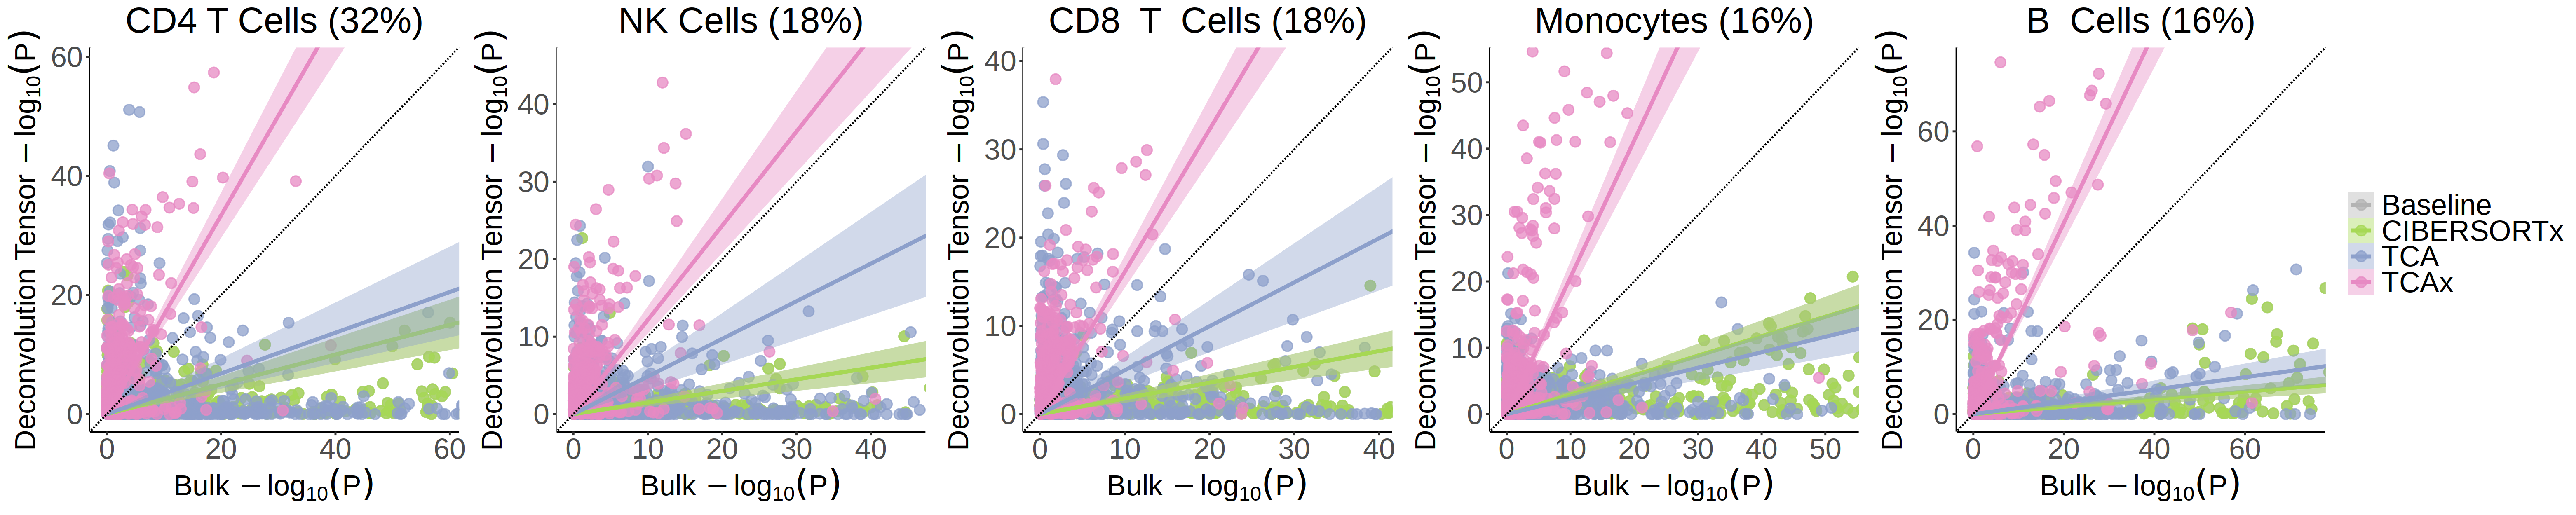

In [71]:
g = egg::ggarrange(plots = plts, align = "h", widths = rep(1, k)) 

# pdf(file.path(project.dir,"Orthognal/figure",paste0("orthognal.h2h.",version,".pdf")), height = 5, width = 22, onefile=FALSE)
# g
# dev.off()